#**Kaggle CTR prediction**


**Features Analysis**


Imports & GPU initializing

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print( '\n\nThis error most likely means that this notebook is not ' 'configured to use a GPU. Change this in Notebook Settings via the ' 'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
root_dir = "/content/drive/shared drives/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading training files

In this part we load random training files for features analysis.
We performed the analysis several time for different files and subsets, to ensure that the relations and features' properties remain.

since sklearn cannot process very large files, we selected 10000 random rows to further analysis. we made this selection few times over different files, and expected to see the same results.

In [ ]:
import random
filename = '/content/drive/Shared drives/CTR-PRD/train/part-00007.csv'
train = pd.read_csv(filename,verbose = False)
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 10000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s))
train_partial = pd.read_csv(filename, skiprows=skip)

In [ ]:
train_partial.head(10)

,page_view_start_time,user_id_hash,target_id_hash,syndicator_id_hash,campaign_id_hash,empiric_calibrated_recs,empiric_clicks,target_item_taxonomy,placement_id_hash,user_recs,user_clicks,user_target_recs,publisher_id_hash,source_id_hash,source_item_type,browser_platform,os_family,country_code,region,day_of_week,time_of_day,gmt_offset,is_click
0,1587148255334,c200fa7f009e05a4f58480b145b83fd90636a6e1000068...,418dc37ba86854fc6bbf659ee9547787d580cf9b4bbe9f...,d9c04132bce53c7de71c1b2f3f415460986f053a088bf3...,a1df50275ae35e7c2ed6167e4e7066b19cb76129eac8c4...,37463.336000,22291.0,LIFE~HEALTH,e462c317e1717cb7c0cc5974bfe37c5eaaec5056048360...,15.0,0.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,340b37b630a7c1be1e7efb410389c85bc683998edb69d8...,video,DESK,6,US,NC,5,14,-400,1.0
1,1586211686639,ac82d622aa2ab7396bd94dd23f373ee172729caaa85d59...,a121414eede8630b38ec7368707f9ef8771616118bf3c1...,139d1b7d4e3d66843ff0fffcda0e073a5a7b0ec050338b...,55e54997c2099f1eed1084a1f14698c20d33ef71da31f1...,268875.500000,45205.0,TECH,6055091bd2f1c62e48ee3cb89c8e7f0829edc6a05e9f94...,0.0,0.0,0.0,f8a7ba9b7c9b05464ee98daac522b3f3d2376453c70e57...,389b69708cf58731e78e2e023a8c608d886fe5aebc0e23...,category,DESK,6,US,NV,1,15,-700,0.0
2,1586605161905,a46b5160d7a2f7d2e01e00af698435ee1ab23155226657...,673901b0038c01e6c40805ae2cbac3a8cde84589b2bff3...,984e3c4855e104050ca08b105b3417ba45f7d881229c57...,84a24447c36da2015fa7b184a6407c60265e6468dda9cb...,6.673440,13.0,BUSINESS,0be59f651068b35dc1952bba132fe3fc7b656af89e20df...,300.0,28.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,3ad50b325bbdd4353e8e50c5798b2b8ef562924099cb4d...,photo,PHON,3,US,KS,6,6,-500,0.0
3,1587000853317,6b794cae447db776a90d9a3854cdcda2e4ab0d76384cdb...,efb88432591322b77a6e0efb890deea319b14f57e95e22...,01075d7ac621dfcabf1eac71dca223d017ace376225b51...,20ae10c6ca354c3f4faefb62528dd61176499ae1d76d7d...,442.041320,1306.0,LIFE~FOOD,3d1a6e10ccba992a0cec1d9b67cd13b2033892ac6a6a43...,378.0,206.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,964c5134efe0cc527086ed9e4e7c26e0edbfe87c1dab3f...,text,PHON,3,US,AR,3,20,-500,1.0
4,1586867559444,5dd6a1bd063a51838db6d32a20c938dd05a2b2b72e0854...,4aa356a400df3a9805888d7d11735cd08daf5ffecde570...,5b74ed105383cdf56c91bef5ab92eb9e2302571a008cc2...,cfe2cfced1e6bd953acf8f68f28d5f56221a84beef247f...,1115.332900,4227.0,UNKNOWN,e1999a72622caae58e94f73f9789b22b3f849ef0b11f6e...,408.0,4.0,1.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,b75003275304064ca2838c4ee0139b1374e482bd81156d...,text,DESK,6,US,NY,2,8,-400,0.0
5,1587097872223,8e11f2bbae648b02be8de54ccb40e7168bb985f0f8bc08...,cd21fe599c5dd0013d04935eeefd265d009a56958b6c8d...,733eae957fba25a060d9b28810ea6edb9b5e2a9d2d7241...,b7eff0ca2e6fb2b99e0b0bda8e169c939884d4e99dad4a...,48.223564,100.0,SPORTS,b1c0e2baa89e19c667a4c77835b2b1ccbbe87960f6a64b...,458.0,20.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,63d71a18f2c03a60170129c1e487a6c2fdd42014695e00...,text,DESK,6,US,MO,4,23,-500,1.0
6,1586619227734,a9e3a44cacd49f894861562fb72cc82fcd43359bec61a1...,5b9c3bf1bad9fae59d98122425bd871cc94323a12351b5...,22fe3033fa3934361e778318421398669b17ef75991710...,762c8d785d57c2c3a2ce0c4b2d114b56f16bc269afbf72...,2579.814700,9924.0,LIFE~PETS,f1b3343d5e6491da91d7c65d1ad3140bb1983eedb1ed2d...,1429.0,45.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,64079ef22d9eb45a06e73973b9a73c530ca26ab20648c6...,text,DESK,6,US,VA,6,11,-400,1.0
7,1587062026675,06f43fb5040f40df34bcaf1ce10f03d592cffaa42fb7f4...,264bf1a745313e8e3c15cef17f97622ca6c5dbed23e682...,00969476791e522c12df362a27e2c03e99223b3679f233...,ea6262ed2f507396ece6c21678f7e33bf3e0b916d8e749...,69749.100000,28407.0,BUSINESS,d016615fd0d41dc3dcc4d36ba1f0fddeda327864ded9b5...,0.0,0.0,0.0,c29a980222a2a97b74ffbd067f2a4ce760e3e8d8f02494...,4c7987d659b97d2007c45bb3c9fd903b135a2ef18130f7...,homepage,PHON,2,US,ME,4,14,-400,1.0
8,1586976427284,9d3c1d55b49e1d98d73778b7dab3fa8b1cca92382fc28f...,b59d0359cbc20a6f48d630dcdb4ca20905457403d557d5...,31014fa25972241

# Features correlations and Importance

We will use 3 methods to try and understand our data. by doing that, we can recognize which are the meaningful features that are most important for our model.

**features correlations and importance**

we will try to recognize features correlation and their affect on the target variable (is click).

**Heatmap**

we will start with heatmap to look for general correlations:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


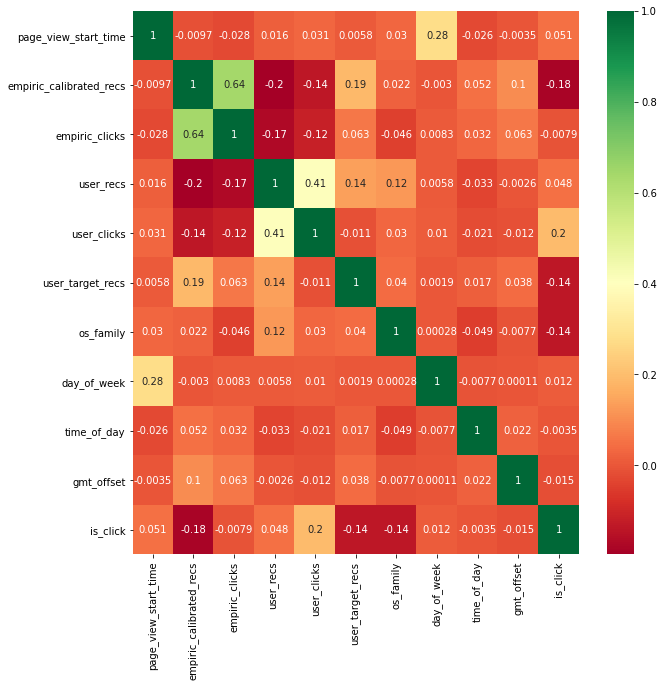

In [ ]:
'''heatmap'''
import seaborn as sns
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Lets see how the heatmap looks for other training file.

we are expecting to see very similar data, so the correletions between features will be the same.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


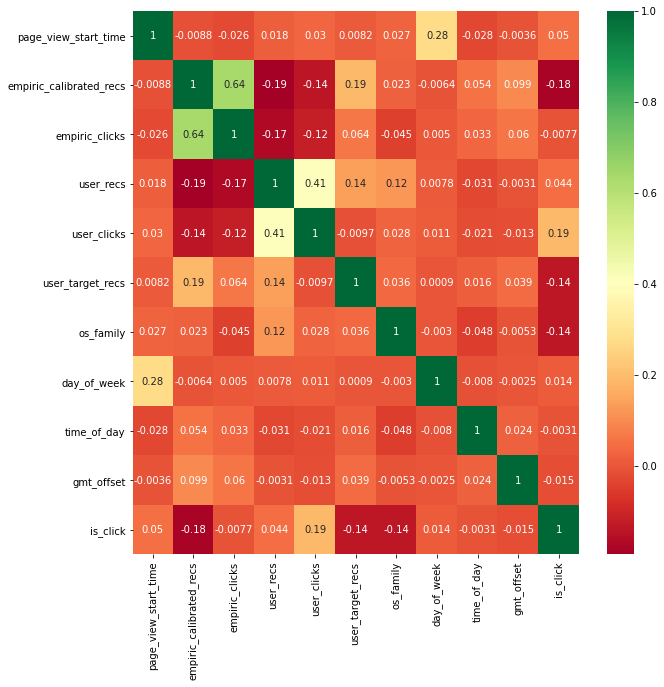

In [ ]:
'''heatmap on different file'''
import seaborn as sns
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Heatmap shows us some connections between those features:
empiric_calibrated_recs,
empiric_clicks,
user_recs,
user_clicks,
and: user_target_recs.

we can also see that some features affect the target: empiric_calibrated_recs ,user_clicks, user_target_recs,os_family, user_recs.


**features importances**

Now, we will estimate feature importance by using ExtraTreeClassifier:


[1.73641233e-02 1.47785112e-02 1.61352976e-02 ... 6.52505834e-06
 4.75417729e-05 7.35531929e-07]


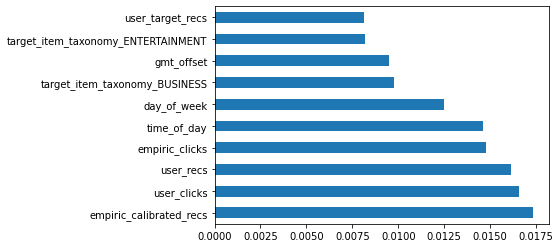

In [ ]:
'''feature importance'''
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

top 3 are empiric_calibrated, user_clicks and user_recs - we saw this connection on heatmap as well. we also see importance of empiric_clicks, time features and 2 taxonomy options:
 Entertainment and business.


**univariate selection**

We will use univariate selection that help us select the best features based on univariate statistical tests. here we use Xi2 test.

In [ ]:
'''univariate selection'''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
Xt = train_partial.iloc[:,:-1]
cols = (Xt.columns).tolist()
cols.pop(0)
X = pd.get_dummies(Xt[cols])
X['gmt_offset'] = train_partial['gmt_offset'].abs()
y = train_partial['is_click']
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                                   Specs         Score
0                                empiric_calibrated_recs  4.596473e+07
3                                            user_clicks  3.032500e+04
1                                         empiric_clicks  2.321167e+04
2                                              user_recs  6.105539e+03
4                                       user_target_recs  1.994351e+03
14082  syndicator_id_hash_139d1b7d4e3d66843ff0fffcda0...  2.299334e+02
17548                          target_item_taxonomy_TECH  2.148603e+02
17506                      target_item_taxonomy_BUSINESS  2.122702e+02
21318                              browser_platform_PHON  2.077094e+02
17512                 target_item_taxonomy_ENTERTAINMENT  1.960324e+02


In [ ]:
'''univariate selection - for other random subset'''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
Xt = train_partial.iloc[:,:-1]
cols = (Xt.columns).tolist()
cols.pop(0)
X = pd.get_dummies(Xt[cols])
X['gmt_offset'] = train_partial['gmt_offset'].abs()
y = train_partial['is_click']
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                                   Specs         Score
0                                empiric_calibrated_recs  5.661401e+07
1                                         empiric_clicks  5.265930e+04
3                                            user_clicks  2.597515e+04
2                                              user_recs  5.283501e+03
4                                       user_target_recs  2.264863e+03
8                                             gmt_offset  3.616653e+02
17659                      target_item_taxonomy_BUSINESS  2.599453e+02
14147  syndicator_id_hash_139d1b7d4e3d66843ff0fffcda0...  2.526691e+02
17665                 target_item_taxonomy_ENTERTAINMENT  2.375043e+02
17703                          target_item_taxonomy_TECH  2.051415e+02


we can see that the features that achieve highest score are empiric_calibrated, user_clicks_empiric_clicks, user_recs and user_target_recs. 

This fits our previous analysis! we will keep these features for further processing, since it looks that they might be important to our model.



Lets see if we can learn something about correlation between empiric_calibrated_rec and cmpiric_clicks:


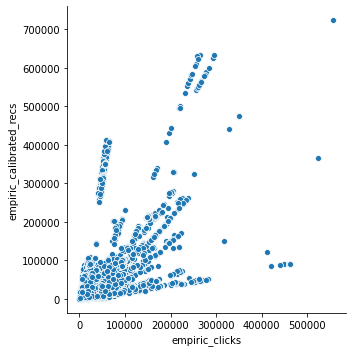

In [ ]:
import seaborn as sns
df = pd.DataFrame(train_partial, columns=['empiric_calibrated_recs', 'empiric_clicks'])
sns.relplot(data=df,x="empiric_clicks",y="empiric_calibrated_recs");

looks like they have positive correlation, as seen in heatmap as well.
what about user_recs and user_clicks?


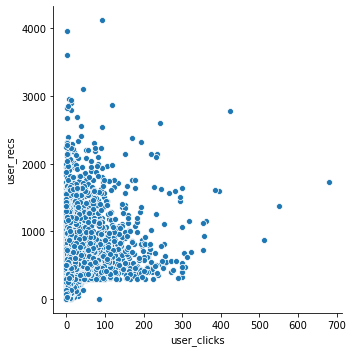

In [ ]:
df = pd.DataFrame(train_partial, columns=['user_recs', 'user_clicks'])
sns.relplot(data=df,x="user_clicks",y="user_recs");

Not very significant. what about empiric_calibrated_recs and user_target_recs?

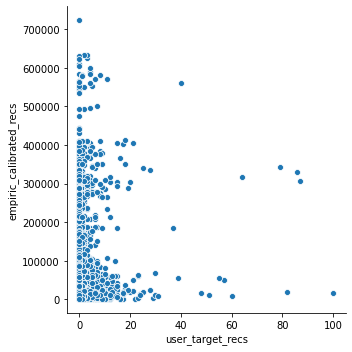

In [ ]:
df = pd.DataFrame(train_partial, columns=['user_target_recs', 'empiric_calibrated_recs'])
sns.relplot(data=df,x="user_target_recs",y="empiric_calibrated_recs");

Also not significant. we will move on, to look closely on the features.

# Features Quantities and Distributions

In this part we will look closely over some of the interesting features, to see what we can learn from them.

We will start by checking unique quantities of each feature.



In [ ]:
def print_quantities(col):
  print("There are {} unique {} in the data set".format(train[col].nunique(),col))
print ("total records in train set:", len(train)) 
for col in train.columns:
  print_quantities(col)

total records in train set: 462734
There are 462170 unique page_view_start_time in the data set
There are 450019 unique user_id_hash in the data set
There are 28273 unique target_id_hash in the data set
There are 1953 unique syndicator_id_hash in the data set
There are 12799 unique campaign_id_hash in the data set
There are 182893 unique empiric_calibrated_recs in the data set
There are 45408 unique empiric_clicks in the data set
There are 60 unique target_item_taxonomy in the data set
There are 1082 unique placement_id_hash in the data set
There are 3038 unique user_recs in the data set
There are 512 unique user_clicks in the data set
There are 95 unique user_target_recs in the data set
There are 3 unique publisher_id_hash in the data set
There are 35074 unique source_id_hash in the data set
There are 5 unique source_item_type in the data set
There are 4 unique browser_platform in the data set
There are 7 unique os_family in the data set
There are 219 unique country_code in the data s

Now, we can have closer look of values distributions


c83159630182a5b7bc3c3fc985156c03b2a43129d6337622f290e2071c9e103661f473032e7839658b0f59a8a8802cf8c90b0b09ee75d5733050079ecf5c7c46    117963
4c7987d659b97d2007c45bb3c9fd903b135a2ef18130f7bae03ce4daa403c1be16116ff69e52f755055e187efaaa356659824b3a9936553cc11fe96aebf178e8     68580
389b69708cf58731e78e2e023a8c608d886fe5aebc0e23ae62ed16356a6f17a5abb5fc84890df1d92e3e0dad306d5ecccace2408329538355af402a49a7762d6     45858
e90276bd1ecb64d287d924dfbc60a8328652248e00c399091a62636571807b71830c3daa4723c1be29cf4a7e0d491ee684c0f88fb66438800deaf653c2f090d3      1115
973e5290dc2d246f1a21afd3676e2bde5d7597247ec268b1425849031216970244acd635b97689a9c0403a28a2cc856c2c5b50189c97b51c8a29f49071950cb9       963
                                                                                                                                     ...  
e2a8f860a002af4bf25b1745030adaeda30857b0b729162eb08355638be2aa5b6685a7cb71be485258c05eabcf27090d8f6194f53947d7d6ba2673a455c4b087         1
d560ab33ff27ebcc7c039fb9f8e

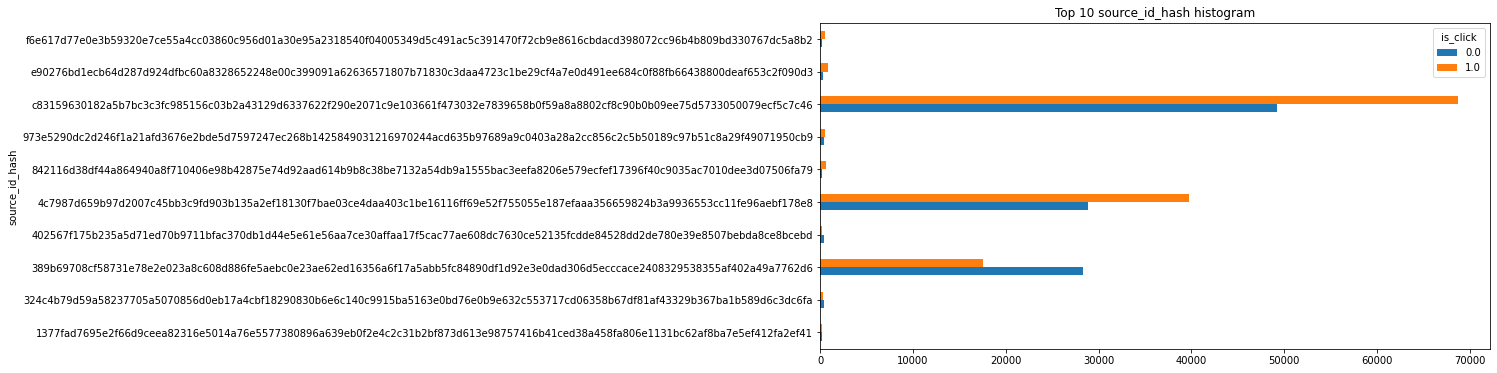

In [ ]:
'''source_id_hash '''
print (train.source_id_hash.value_counts())
print("There are {} source_id_hash  in the data set".format(train.source_id_hash.nunique()))
top10_sites = train[(train.source_id_hash.isin((train.source_id_hash.value_counts()/len(train))[0:10].index))]
top10_sites_click = top10_sites[top10_sites['is_click'] == 1]
top10_sites.groupby(['source_id_hash', 'is_click']).size().unstack().plot(kind='barh', figsize=(12,6), title='Top 10 source_id_hash histogram');

**source hash id** shows us that there are 3 very popular sources, leads by far the others, that are the sources of more than 50% of the records.

We will check the histogram for another training file, which gives the same results:

c83159630182a5b7bc3c3fc985156c03b2a43129d6337622f290e2071c9e103661f473032e7839658b0f59a8a8802cf8c90b0b09ee75d5733050079ecf5c7c46    122172
4c7987d659b97d2007c45bb3c9fd903b135a2ef18130f7bae03ce4daa403c1be16116ff69e52f755055e187efaaa356659824b3a9936553cc11fe96aebf178e8     70589
389b69708cf58731e78e2e023a8c608d886fe5aebc0e23ae62ed16356a6f17a5abb5fc84890df1d92e3e0dad306d5ecccace2408329538355af402a49a7762d6     47293
e90276bd1ecb64d287d924dfbc60a8328652248e00c399091a62636571807b71830c3daa4723c1be29cf4a7e0d491ee684c0f88fb66438800deaf653c2f090d3      1150
973e5290dc2d246f1a21afd3676e2bde5d7597247ec268b1425849031216970244acd635b97689a9c0403a28a2cc856c2c5b50189c97b51c8a29f49071950cb9       988
                                                                                                                                     ...  
05f79b0ec565a9ae0e0ffef9379185ab8217853699d0107bb8e2004f0e0777bcb215ecf292b41580f029e50d901aad2ceb66aadb43a3616c92e8a66e741b74f9         1
9a78ea7f122ef0378c4ecba5f01

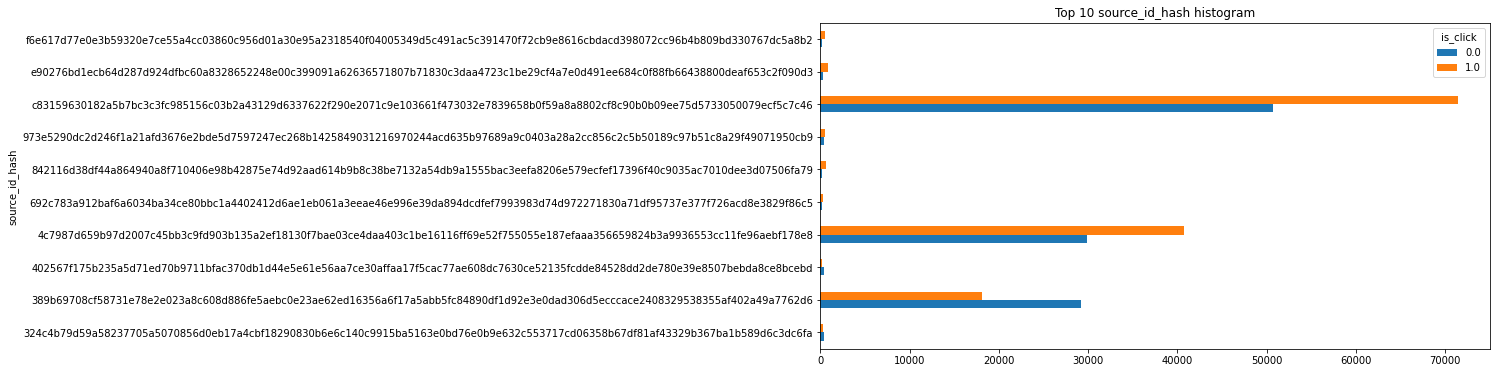

In [ ]:
'''source_id_hash '''
print (train.source_id_hash.value_counts())
print("There are {} source_id_hash  in the data set".format(train.source_id_hash.nunique()))
top10_sites = train[(train.source_id_hash.isin((train.source_id_hash.value_counts()/len(train))[0:10].index))]
top10_sites_click = top10_sites[top10_sites['is_click'] == 1]
top10_sites.groupby(['source_id_hash', 'is_click']).size().unstack().plot(kind='barh', figsize=(12,6), title='Top 10 source_id_hash histogram');

0.0        10919
1.0         2789
2.0         1572
3.0          966
4.0          911
           ...  
93313.0        1
64158.0        1
11665.0        1
50002.0        1
27521.0        1
Name: empiric_clicks, Length: 45408, dtype: int64
There are 45408 empiric_clicks  in the data set


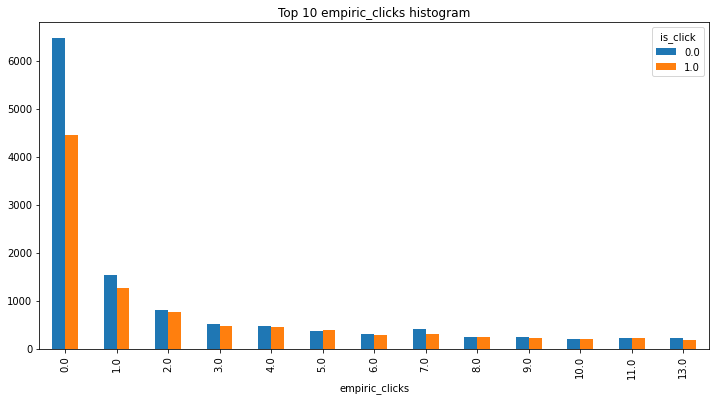

In [ ]:
'''empiric_clicks '''
print (train.empiric_clicks.value_counts())
print("There are {} empiric_clicks  in the data set".format(train.empiric_clicks.nunique()))
top10_sites = train[(train.empiric_clicks.isin((train.empiric_clicks.value_counts()/len(train))[0:10].index))]
top10_sites_click = top10_sites[top10_sites['is_click'] == 1]
top10_sites.groupby(['empiric_clicks', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 empiric_clicks histogram');


**empiric clicks** shows that most of the users has no clicks, and others have few.


0.0     359566
1.0      48183
2.0      20165
3.0      10103
4.0       6254
         ...  
89.0         1
78.0         1
72.0         1
91.0         1
83.0         1
Name: user_target_recs, Length: 95, dtype: int64
There are 95 user_target_recs  in the data set


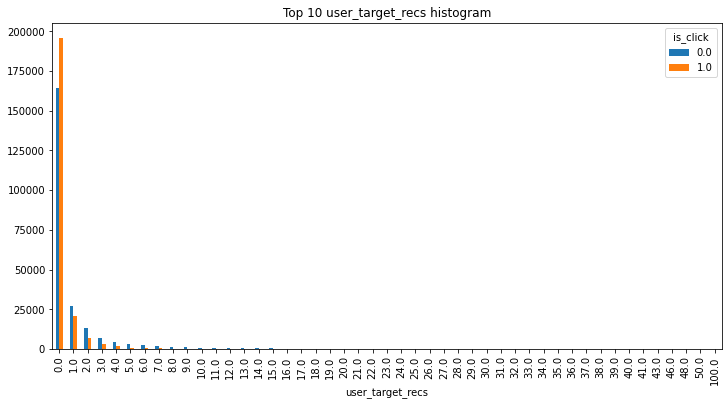

In [ ]:
'''user_target_recs '''

print (train.user_target_recs.value_counts())
print("There are {} user_target_recs  in the data set".format(train.user_target_recs.nunique()))
top10_sites = train[(train.user_target_recs.isin((train.user_target_recs.value_counts()/len(train))[0:50].index))]
top10_sites_click = top10_sites[top10_sites['is_click'] == 1]
top10_sites.groupby(['user_target_recs', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 user_target_recs histogram');

In [ ]:
'''empiric_calibrated_recs'''
print (train.empiric_calibrated_recs.value_counts())
print("There are {} empiric_calibrated_recs  in the data set".format(train.empiric_calibrated_recs.nunique()))
train.groupby(['empiric_calibrated_recs', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='histogram');

0.0      162799
1.0       33934
2.0       22077
3.0       16732
4.0       13349
          ...  
377.0         1
420.0         1
375.0         1
538.0         1
511.0         1
Name: user_clicks, Length: 512, dtype: int64
There are 512 user_clicks  in the data set


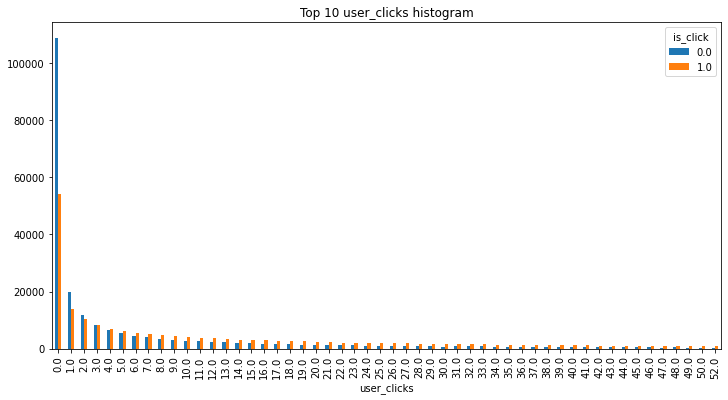

In [ ]:
'''user clicks'''

print (train.user_clicks.value_counts())
print("There are {} user_clicks  in the data set".format(train.user_clicks.nunique()))
top10_sites = train[(train.user_clicks.isin((train.user_clicks.value_counts()/len(train))[0:50].index))]
top10_sites_click = top10_sites[top10_sites['is_click'] == 1]
top10_sites.groupby(['user_clicks', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 user_clicks histogram');


lets see the top targets:

In [ ]:
print('The top 10 target ids that are popular')
print((train.target_id_hash.value_counts()/len(train))[0:10])

There are 28273 sites in the data set
There are 450019 users in the data set
The top 10 target ids that are popular
a121414eede8630b38ec7368707f9ef8771616118bf3c129b56557cd4229362c1c043716237755b4ec1a4c213999a9e39f9dfa6f087b31e3b4c6037cee94793c    0.013090
5aefee4fab4424494528333b12a26910bef9e2870b623d35d7600f0b2794c86a16d65a439454c1555bcdb83747287e8e86caf1567ced862fb93c5f1d77e24821    0.007726
415462704d29d1d343c78d2bb466402adc222f0969d5a997f6c7153358618986a92861bcc6038fec0bda0b2d53d2b4af2dc75827b73da18a6b1bec518acd1456    0.007531
a09364d51ceb7c978b82ff07ac7d456fb3f2856932bacb4208136fb6c18a49befd03423d61c9948c66daf4ea07ceb979e5f1952a095226b64a0be18d1c75d052    0.007391
44b76d7233e43508f509b3e294a34d4f855b3285142a904b01bf731672745003295d85c39938a5aa065fa0138bea6b259afb077f40d8b07c681a07a8bbbe1bbd    0.006055
acb2b5fa7a015c6eeeac1f2c6cf34fa95a2237ad146edcc53ae14163fcd44e14a0f7191e5a68e7ee14eb4b20dedc1daf8965c1a7f3997e0f48a5a005a0fd3684    0.005595
ab11ed65a8a049c72b3ae7a81355c364acdc22

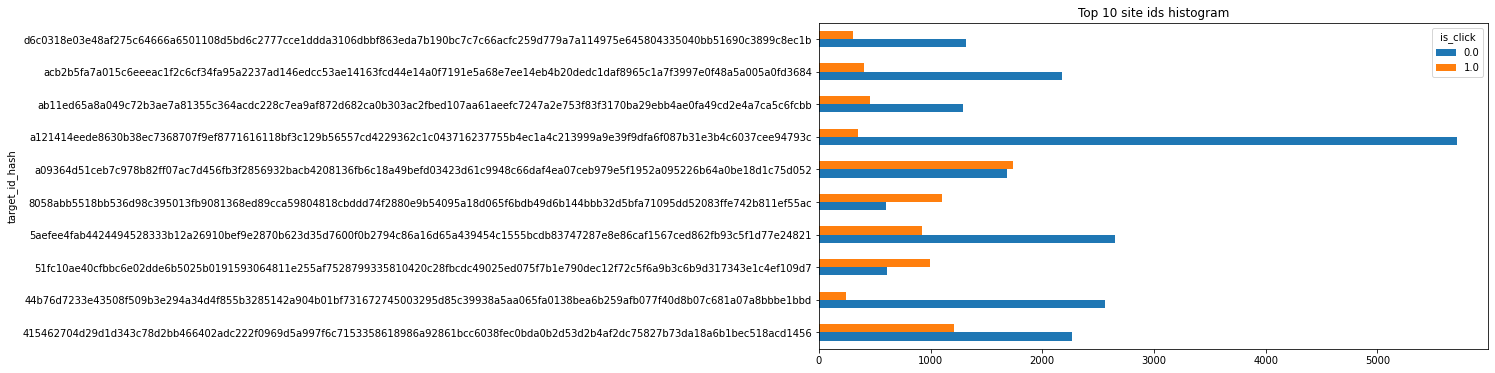

In [ ]:
top10_sites = train[(train.target_id_hash.isin((train.target_id_hash.value_counts()/len(train))[0:10].index))]
top10_sites_click = top10_sites[top10_sites['is_click'] == 1]
top10_sites.groupby(['target_id_hash', 'is_click']).size().unstack().plot(kind='barh', figsize=(12,6), title='Top 10 site ids histogram');

**publisher id hash** is an interesting feature, it contains only 3 possible values. probably not very helpful for learning.

There are 3 publishers in the data set


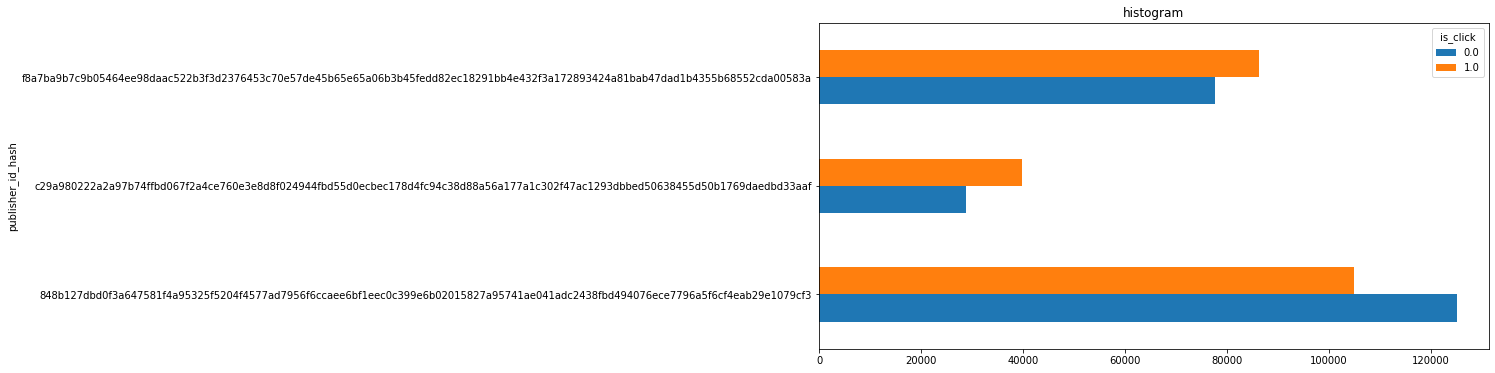

In [ ]:
#publisher_id_hash
print("There are {} publishers in the data set".format(train.publisher_id_hash.nunique()))
train.publisher_id_hash.describe()
train.groupby(['publisher_id_hash', 'is_click']).size().unstack().plot(kind='barh', figsize=(12,6), title='histogram');

**sites category** are interesting - we see that most of the clicks come from Entertainment category, and the rejects (negative connection) come from business category.


There are 60 site categories in the data set


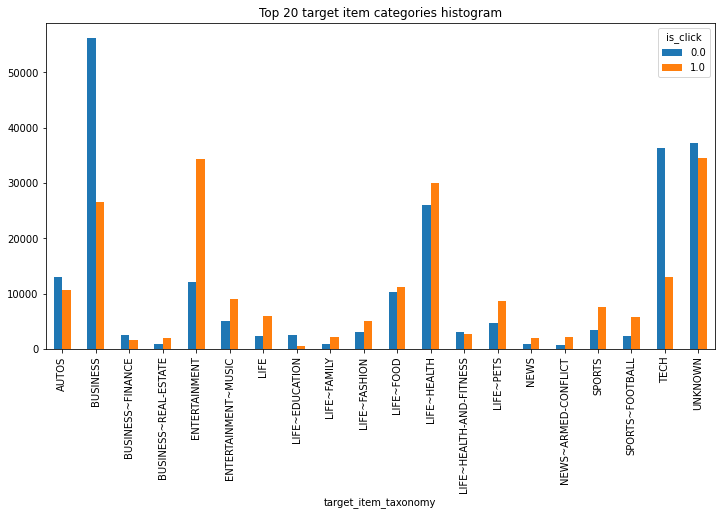

In [ ]:

print("There are {} site categories in the data set".format(train.target_item_taxonomy.nunique()))
top20_category = train[(train.target_item_taxonomy.isin((train.target_item_taxonomy.value_counts()/len(train))[0:20].index))]
top20_category_click = top20_category[top20_category['is_click'] == 1]
top20_category.groupby(['target_item_taxonomy', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 20 target item categories histogram');

here we see the syndicator_id histogram:

There are 1953 syndicator_id_hash in the data set


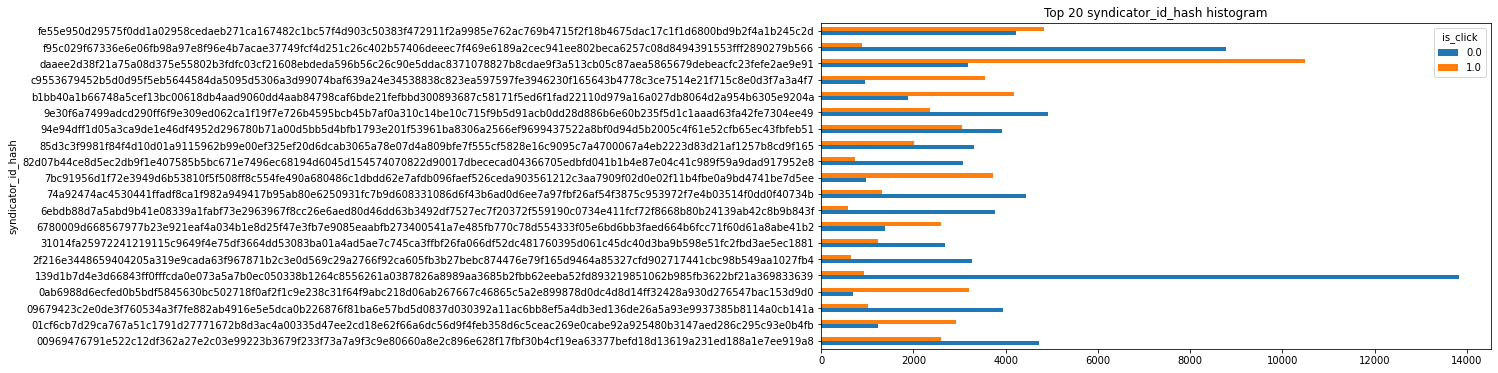

In [ ]:

print("There are {} syndicator_id_hash in the data set".format(train.syndicator_id_hash.nunique()))
top20_category = train[(train.syndicator_id_hash.isin((train.syndicator_id_hash.value_counts()/len(train))[0:20].index))]
top20_category_click = top20_category[top20_category['is_click'] == 1]
top20_category.groupby(['syndicator_id_hash', 'is_click']).size().unstack().plot(kind='barh', figsize=(12,6), title='Top 20 syndicator_id_hash histogram');

we notice that some of them has significant negative affect on clicks, while at least one has pretty positive affect. probably will keep this features for the model.

**time features**

Lets see how time of the day affect clicks:

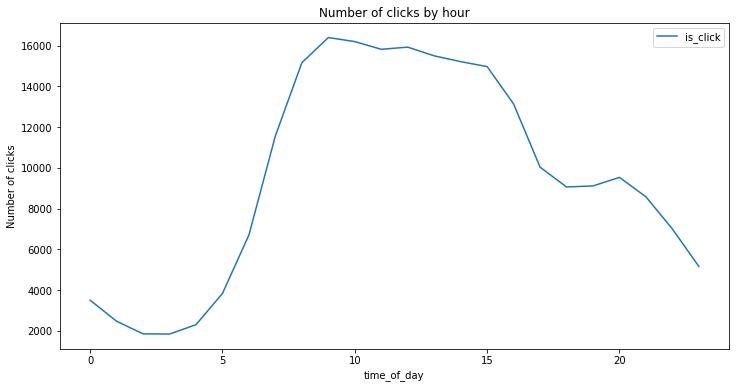

In [ ]:
train.groupby('time_of_day').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

not surprising to see that most of the clicks are occured during work-day, reduced during afternoon and that has small pick an 8pm.

For weekdays, we see positive trends in the beggining and in the end of the week.

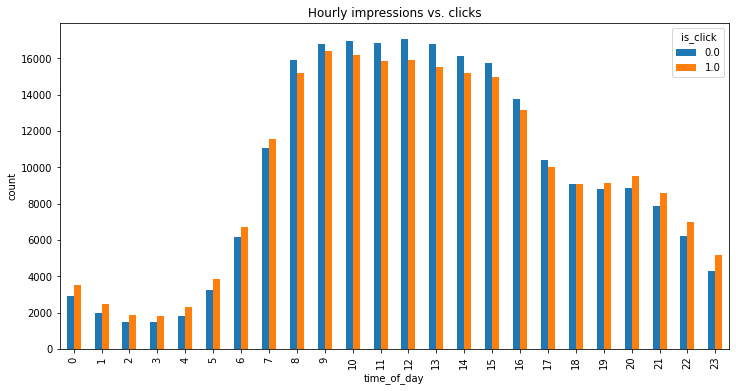

In [ ]:
train.groupby(['time_of_day', 'is_click']).size().unstack().plot(kind='bar', title="Time of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks');


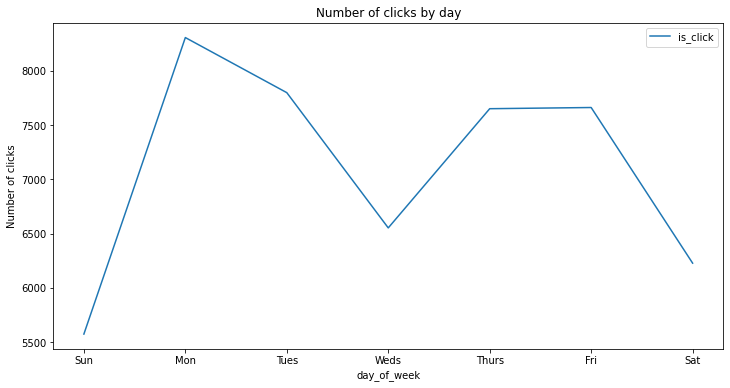

In [ ]:
train.groupby('day_of_week').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
ticks = list(range(0, 7, 1))
labels = "Sun Mon Tues Weds Thurs Fri Sat".split()
plt.xticks(ticks, labels)
plt.title('Number of clicks by day');

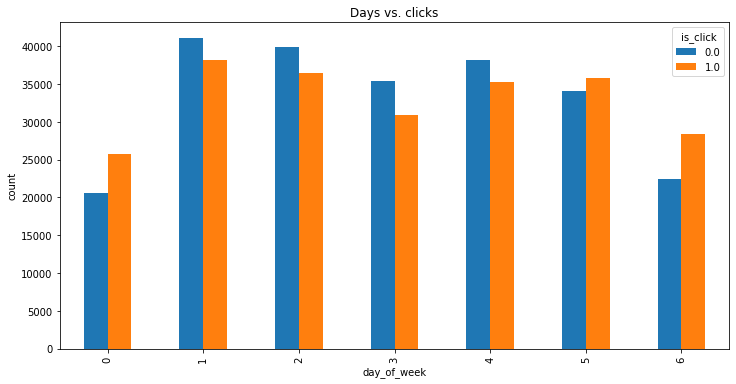

In [ ]:
train.groupby(['day_of_week', 'is_click']).size().unstack().plot(kind='bar', title="Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Days vs. clicks');

**other technical features**

the next features give us a clue about the environments the users are using,

Lets see **source item** options:

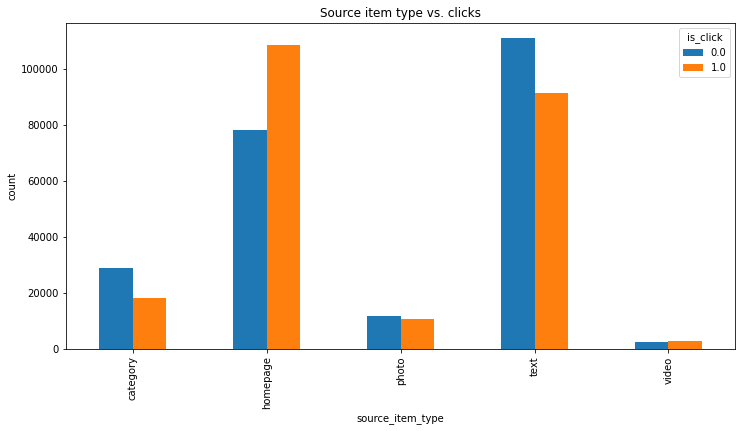

In [ ]:
'''source_item_type '''
train.groupby(['source_item_type', 'is_click']).size().unstack().plot(kind='bar', title="Source item Type", figsize=(12,6))
plt.ylabel('count')
plt.title('Source item type vs. clicks');

so most of users come from homepage or text pages.

In [ ]:
'source_item_type','browser_platform',
                   'os_family','country_code','region'

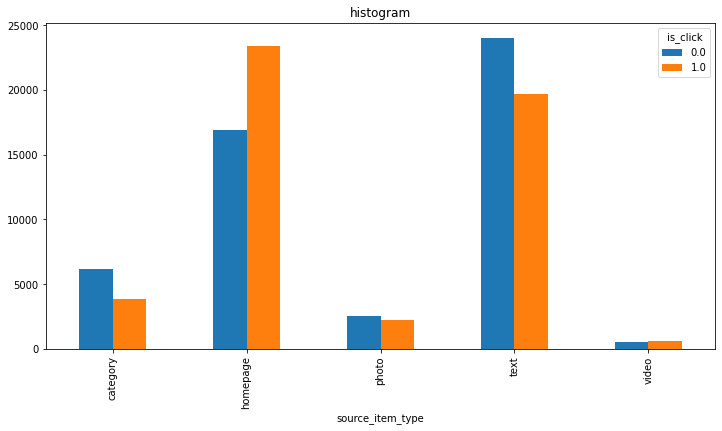

In [ ]:
train.groupby(['source_item_type', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='histogram');

the popular browser platform in Desktops, by far!

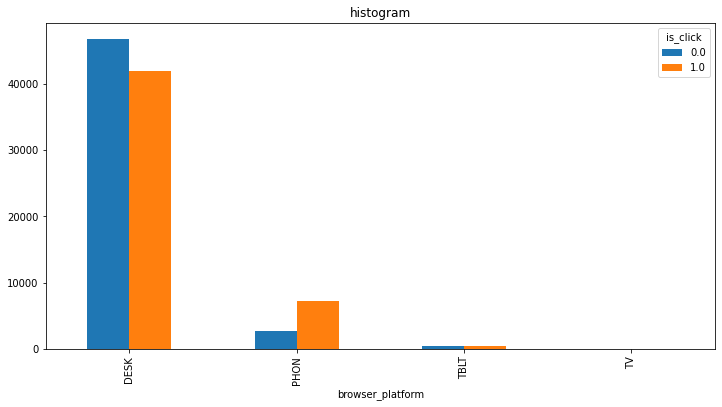

In [ ]:
train.groupby(['browser_platform', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='histogram');

In general, most of the users use desktops, os version 6

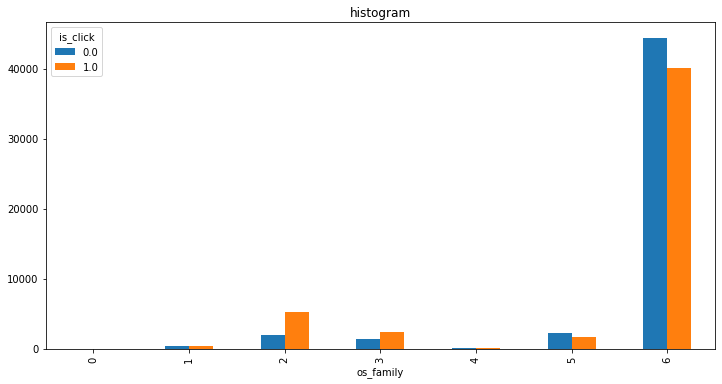

In [ ]:
train.groupby(['os_family', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='histogram');

**Location**

what can we learn about users' location?

Most of the regions are american states, leads by California, Florida and Texas

There are 862 regions in the data set


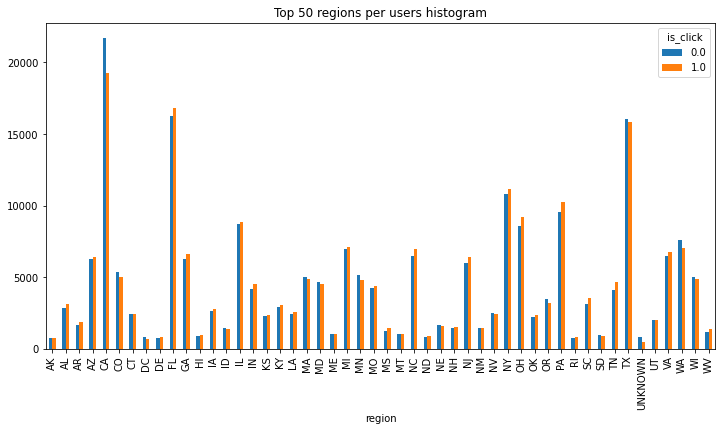

In [ ]:
print("There are {} regions in the data set".format(train.region.nunique()))
top50_region = train[(train.region.isin((train.region.value_counts()/len(train))[0:50].index))]
top50_region_click = top50_region[top50_region['is_click'] == 1]
top50_region.groupby(['region', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 50 regions per users histogram');

As we see, USA is dominated amoung all users countries

There are 219 countrys in the data set


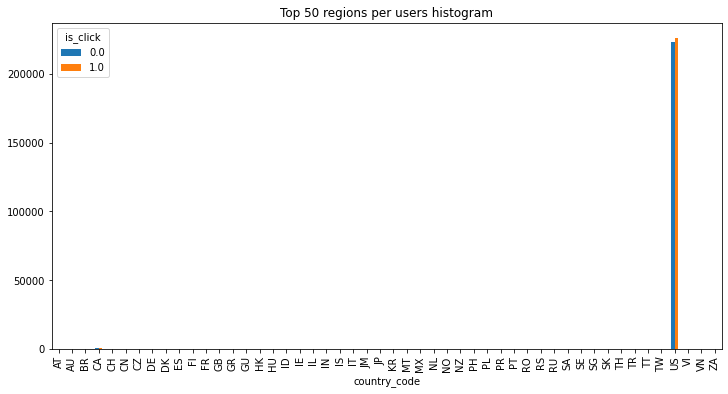

In [ ]:
print("There are {} countrys in the data set".format(train.country_code.nunique()))
top50_region = train[(train.country_code.isin((train.country_code.value_counts()/len(train))[0:50].index))]
top50_region_click = top50_region[top50_region['is_click'] == 1]
top50_region.groupby(['country_code', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 50 regions per users histogram');

In [ ]:
train.country_code.describe()

count     462727
unique       219
top           US
freq      448824
Name: country_code, dtype: object

# Summary

After observing carfully features behaviour, we notice that there are some leading candidates for meaningful features to train part. most of them are numeric, and has some correlation to target value:

they are: **user_recs**, **user_clicks**, **user_target_rec**, **empiric_calibrated_recs**

other features that seem to be relevant are **target_item_taxonomy** and **syndicator_id_hash**, and we will use them to train our model.


In [ ]:
X = train_partial.iloc[:,:-1]
print (X.columns)

Index(['page_view_start_time', 'user_id_hash', 'target_id_hash',
       'syndicator_id_hash', 'campaign_id_hash', 'empiric_calibrated_recs',
       'empiric_clicks', 'target_item_taxonomy', 'placement_id_hash',
       'user_recs', 'user_clicks', 'user_target_recs', 'publisher_id_hash',
       'source_id_hash', 'source_item_type', 'browser_platform', 'os_family',
       'country_code', 'region', 'day_of_week', 'time_of_day', 'gmt_offset'],
      dtype='object')
